# World Water Toolbox

### 1) Authentication 

In [1]:
import openeo
from openeo.extra.spectral_indices.spectral_indices import append_index, append_indices
from openeo.processes import exp, array_element,log, count,normalized_difference, gte, eq, neq, sum
from openeo.processes import if_
import numpy as np
import warnings
import pathlib
from datetime import datetime
from datetime import date
from dateutil.relativedelta import *
import ipywidgets as widgets
import xarray as xr
import scipy
from eo_utils_ANSU import *
import ipywidgets as widgets
from ipywidgets import interact

connection = openeo.connect("openeo.vito.be").authenticate_oidc()  #openeo.cloud  #openeo-dev.vito.be


Authenticated using refresh token.


### 2) Select AOI, Date, Threshold and ecoregions https://ecoregions.appspot.com/

In [2]:
center = [19.462,-99.95]
zoom   = 12.54
eoMap  = openMap(center,zoom)


zone_w = widgets.RadioButtons(
    options=['Deserts', 'Mountain','Tropical forest','Tropical savanna','Subtropical forest',
             'Subtropical savanna','Temperate broadleaf','Temperate grassland'],
    layout={'width': 'max-content'},
    description='Ecoregions',
    disabled=False)


start_date_w = widgets.DatePicker(
    description='Start Date',
    value = date(2021,5,1),
    disabled=False)

threshold = widgets.IntSlider(value =75, description='Threshold',)

display(eoMap.map)
display(start_date_w)
display(threshold)
display(zone_w)

get_data_button = widgets.Button(description='Run',
                                 disabled=False,
                                 button_style='',
                                 tooltip='Click me',
                                 icon='check')
                             

def WWT(b):

    zone = zone_w.value
    get_data_button.disabled = True
    bbox                     = eoMap.getBbox()
    spatial_extent           = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':4326} 
    start_date               = start_date_w.value
    end_date                 = (start_date  + relativedelta(months = +1)) ## End date, 1 month later (1st Feb. 2021)
    start_date_exclusion     = (start_date  + relativedelta(months = -1)) 
    bands                    = ['B02', 'B03', 'B04', 'B08', 'CLP', 'SCL' , 'sunAzimuthAngles', 'sunZenithAngles'] 

    LOOKUPTABLE = {
        
        "Deserts": {
            "S1": lambda vh, vv: 1 / (1 + exp(- (-7.03 + (-0.44 * vv)))),
            "S2": lambda ndvi, ndwi: 1 / (1 + exp(- (0.133 + (-5.92 * ndvi) + (14.82 * ndwi)))),
            "S1_S2": lambda vv, ndvi, ndwi: 1 / (1 + exp(- (-3.69 + (-0.25 * vv) + (0.47 * ndvi) + (15.3 * ndwi)))),
        },
        "Mountain": {
            "S1": lambda vh, vv: 1 / (1 + exp(- (-3.76 + (-0.262 * vv)))),
            "S2": lambda ndvi, ndwi: 1 / (1 + exp(- (0.262 + (0.75 * ndvi) + (12.65 * ndwi)))),
            "S1_S2": lambda vv, ndvi, ndwi: 1 / (1 + exp(- (-1.13 + (-0.11 * vv) + (3.03 * ndvi) + (13.21 * ndwi)))),
        },
        "Tropical forest":
            {
                "S1": lambda vh, vv: (1 / (1 + exp(- (-5.8 + (-0.415 * vv))))),
                "S2": lambda ndvi, ndwi: (1 / (1 + exp(- (0.344 + (2.886 * ndvi) + (11.91 * ndwi)))))*100,
                "S1_S2": lambda vv, ndvi, ndwi: (1 / (1 + exp(- (-3.25 + (-0.23 * vv) + (4.17 * ndvi) + (9.5 * ndwi))))),
        },
         "Tropical savanna":
            {
                "S1": lambda vh, vv: (1 / (1 + exp(- (-7.0 + (-0.444 * vv))))),
                "S2": lambda ndvi, ndwi: (1 / (1 + exp(- (0.344 + (2.886 * ndvi) + (11.91 * ndwi)))))*100,
                "S1_S2": lambda vv, ndvi, ndwi: (1 / (1 + exp(- (-1.06 + (-0.17 * vv) + (3.82* ndvi) + (14.4* ndwi))))),
        },
        "Subtropical savanna":
            {
                "S1": lambda vh, vv: 1 / (1 + exp(- (-7.17 + (-0.48 * vv)))),
                "S2": lambda ndvi, ndwi: 1 / (1 + exp(- (0.845 + (2.14 * ndvi) + (13.5 * ndwi)))),
                "S1_S2": lambda vv, ndvi, ndwi: 1 / (1 + exp(- (-2.64 + (-0.23 * vv) + (8.6 * ndwi)))),
        },
        "Subtropical forest":
            {
                "S1": lambda vh, vv: 1 / (1 + exp(- (-6.67 + (-6.67* vv)))),
                "S2": lambda ndvi, ndwi: 1 / (1 + exp(- (0.712 + (-1.133 * ndvi) + (7.16 * ndwi)))),
                "S1_S2": lambda vv, ndvi, ndwi: 1 / (1 + exp(- (-2.72 + (-0.22 * vv) + (-0.49  * ndvi) + 4.55 * ndwi))),
        },
        "Temperate broadleaf":
            {
            "S1": lambda  vh, vv: 1 / (1 + exp(- (-8.82 + (-0.58 * vv)))),
            "S2": lambda ndvi, ndwi: 1 / (1 + exp(- (-0.013 + (5.38 * ndvi)) + (13.79 * ndwi))),
            "S1_S2": lambda vv, ndvi, ndwi: 1 / (1 + exp(- (-2.7 + (-0.2 * vv)) + (3.6 * ndvi)) + (9.73 * ndwi))
        },
        "Temperate grassland":
            {
            "S1": lambda  vh, vv: 1 / (1 + exp(- (-7.01 + (-0.426 * vv)))),
            "S2": lambda ndvi, ndwi: 1 / (1 + exp(- (1.286 + (8.74 * ndvi)) + (23.217 * ndwi))),
            "S1_S2": lambda vv, ndvi, ndwi: 1 / (1 + exp(- (-3.43 + (-0.25 * vv)) + (11.74 * ndvi)) + (22.035 * ndwi))
            }
        }



    s2_cube = connection.load_collection(
        'SENTINEL2_L2A_SENTINELHUB',
        spatial_extent=spatial_extent,
        temporal_extent=[start_date_exclusion, end_date],
        bands=['B02', 'B03', 'B04', 'B08', 'sunAzimuthAngles', 'sunZenithAngles'])

    s2_cube_masking = connection.load_collection(
        'SENTINEL2_L2A_SENTINELHUB',
        spatial_extent=spatial_extent,
        temporal_extent=[start_date_exclusion, end_date],
        bands=['CLP', 'SCL'])

    scl = s2_cube_masking.band("SCL")
    mask_scl = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10) | (scl == 11)

    clp = s2_cube_masking.band("CLP")
    mask_clp = mask_scl | (clp / 255) > 0.3
    s2_cube = s2_cube.mask(mask_clp.resample_cube_spatial(s2_cube))
    s2_count = s2_cube.filter_bands(bands=["B08"])
    s2_count = s2_count.reduce_dimension(reducer=lambda data: data.count(), dimension="t")
    s2_count = s2_count.rename_labels("bands", ["count"])
    s2_cube = append_indices(s2_cube, ["NDWI","NDVI"]) 

    def water_function(data):
        return LOOKUPTABLE[zone]["S2"](ndwi=data[6], ndvi=data[7])

    s2_cube_water = s2_cube.reduce_dimension(reducer=water_function, dimension="bands")
    s2_cube_water = s2_cube_water.add_dimension("bands", "water_prob", type="bands")

    s2_cube_water_threshold = s2_cube_water.apply_dimension(dimension="bands", process=lambda x: if_(x > 0.75, x, 0))
    s2_cube_water_threshold = s2_cube_water_threshold.rename_labels("bands", ["w_T75"])

    s2_cube_water_sum = s2_cube_water_threshold.reduce_dimension(reducer="sum", dimension="t")
    s2_cube_water_sum = s2_cube_water_sum.rename_labels("bands", ["sum"])

    s2_cube_swf = s2_cube_water_sum.resample_cube_spatial(s2_count) / s2_count
    s2_cube_swf = s2_cube_swf.rename_labels("bands", ["swf"])

    s2_median_water = s2_cube_water.filter_temporal([start_date, end_date]).median_time()
    s2_cube_median = s2_cube.filter_temporal([start_date, end_date]).median_time()

    s1_cube = connection.load_collection(
        'SENTINEL1_GRD',
        spatial_extent=spatial_extent,
        temporal_extent=[start_date, end_date],
        bands=['VH', 'VV'],
        properties={"polarization": lambda p: p == "DV"})

    s1_cube = s1_cube.sar_backscatter(coefficient="gamma0-terrain", mask=True, elevation_model="COPERNICUS_30")

    s1_cube = s1_cube.rename_labels("bands", ["VH", "VV", "mask", "incidence_angle"])
    s1_cube_mask = s1_cube.band("mask")
    s1_mask_RS = (s1_cube_mask == 2)
    s1_cube = s1_cube.mask(s1_mask_RS)

    def log_(x):
        return 10 * log(x, 10)
    s1_median = s1_cube.median_time().apply(log_)

    def s1_water_function(data):
        return LOOKUPTABLE[zone]["S1"](vh=data[0], vv=data[1])

    s1_median_water = s1_median.reduce_dimension(reducer=s1_water_function, dimension="bands")
    exclusion_mask = (s1_median_water.resample_cube_spatial(s2_cube_swf) > 0.5) & (s2_cube_swf < 0.33)
    s1_median_water_mask = s1_median_water.mask(exclusion_mask.resample_cube_spatial(s1_median_water))


    def s1_s2_water_function(data):
        return LOOKUPTABLE[zone]["S1_S2"](vv=data[0], ndvi=data[1], ndwi=data[2])

    s1_s2_cube = s1_median.filter_bands(['VV']).resample_cube_spatial(s2_cube_median).merge_cubes(s2_cube_median.filter_bands(['NDVI','NDWI'])) 
    s1_s2_water = s1_s2_cube.reduce_dimension(reducer=s1_s2_water_function, dimension="bands").add_dimension("bands", "var", type="bands")
                      
    s1_s2_mask = (s1_s2_water >= 0)
    s2_mask = s2_median_water.mask(s1_s2_mask) >= 0
    s1_mask = s1_median_water.mask(s1_s2_mask).mask(s2_mask) >= 0
    s1_s2_masked = s1_s2_water.mask(s1_s2_mask.apply(lambda x: x.eq(0)), replacement = 0)
    s2_masked = s2_median_water.mask(s2_mask.apply(lambda x: x.eq(0)), replacement = 0)
    s1_masked = s1_median_water.mask(s1_mask.apply(lambda x: x.eq(0)), replacement = 0)
    
    merge_all = s1_s2_masked.merge_cubes(s2_masked, overlap_resolver='sum').merge_cubes(s1_masked, overlap_resolver='sum')
    worldcover_cube = connection.load_collection("ESA_WORLDCOVER_10M_2020_V1", 
                                            temporal_extent = ['2020-12-30', '2021-01-01'], 
                                            spatial_extent = spatial_extent, 
                                            bands = ["MAP"])
                                         
    builtup_mask = worldcover_cube.band("MAP") == 50
    water_probability = merge_all.mask(builtup_mask.max_time().resample_cube_spatial(merge_all))
    water_probability = water_probability.rename_labels("bands", ["water_prob_sum"])
    
    ouput = water_probability > (threshold.value/100)
    ouput= ouput.rename_labels("bands", ["surface_water"])
    
    output_name = f'WWT_{zone}_{threshold.value}_{date.today()}'
    print(output_name)

    output_save = ouput.save_result(format='netCDF') #GTiff #netCDF
    my_job  = output_save.send_job(title= output_name)
    results = my_job.start_and_wait().get_results()
    results.download_files(output_name)

    print('Done')
    print('Spatial Extent:', spatial_extent)
    print('Start_date, End_date:', start_date, end_date)
    print('Zone:', zone)
    print('Theshold:', threshold)

    return s2_cube

# DISPLAY BUTTON
get_data_button.on_click(WWT)
display(get_data_button)



Map(center=[19.462, -99.95], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

DatePicker(value=datetime.date(2021, 5, 1), description='Start Date')

IntSlider(value=75, description='Threshold')

RadioButtons(description='Ecoregions', layout=Layout(width='max-content'), options=('Deserts', 'Mountain', 'Tr…

Button(description='Run', icon='check', style=ButtonStyle(), tooltip='Click me')

WWT_Tropical savanna_75_2022-11-14
0:00:00 Job 'j-1429f8b3202c46dfa04b7bfa6013fd19': send 'start'


### 3) When the job, then the results of surface water can be visualized:

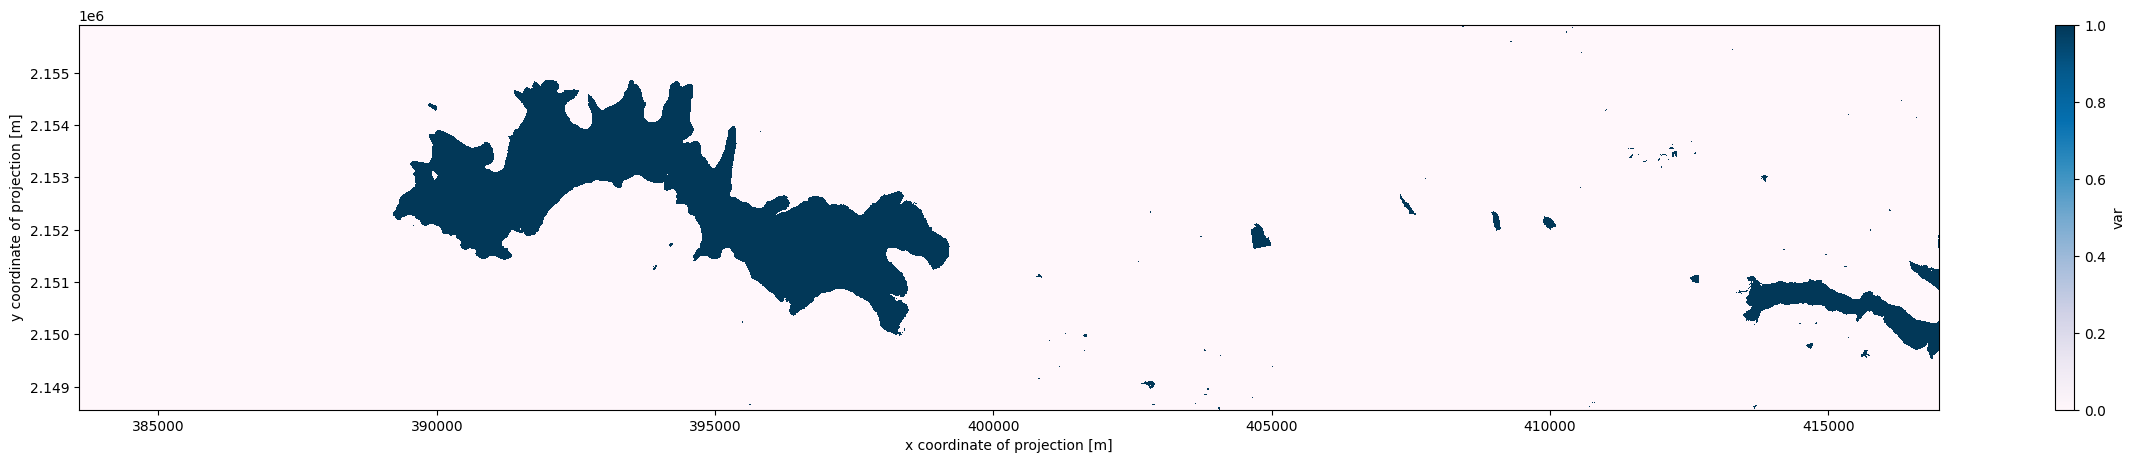

In [15]:
ds_water_prob = xr.open_dataset("WWT_Tropical savanna_70_2022-11-14/openEO.nc").load()
ds_water_prob['var'].plot.imshow(x="x", robust=True, cmap ='PuBu' ,  vmin=0, vmax=1, figsize=(30,5)); 

### 4) Check eith the optical data for the spatial and temporal extent (median):

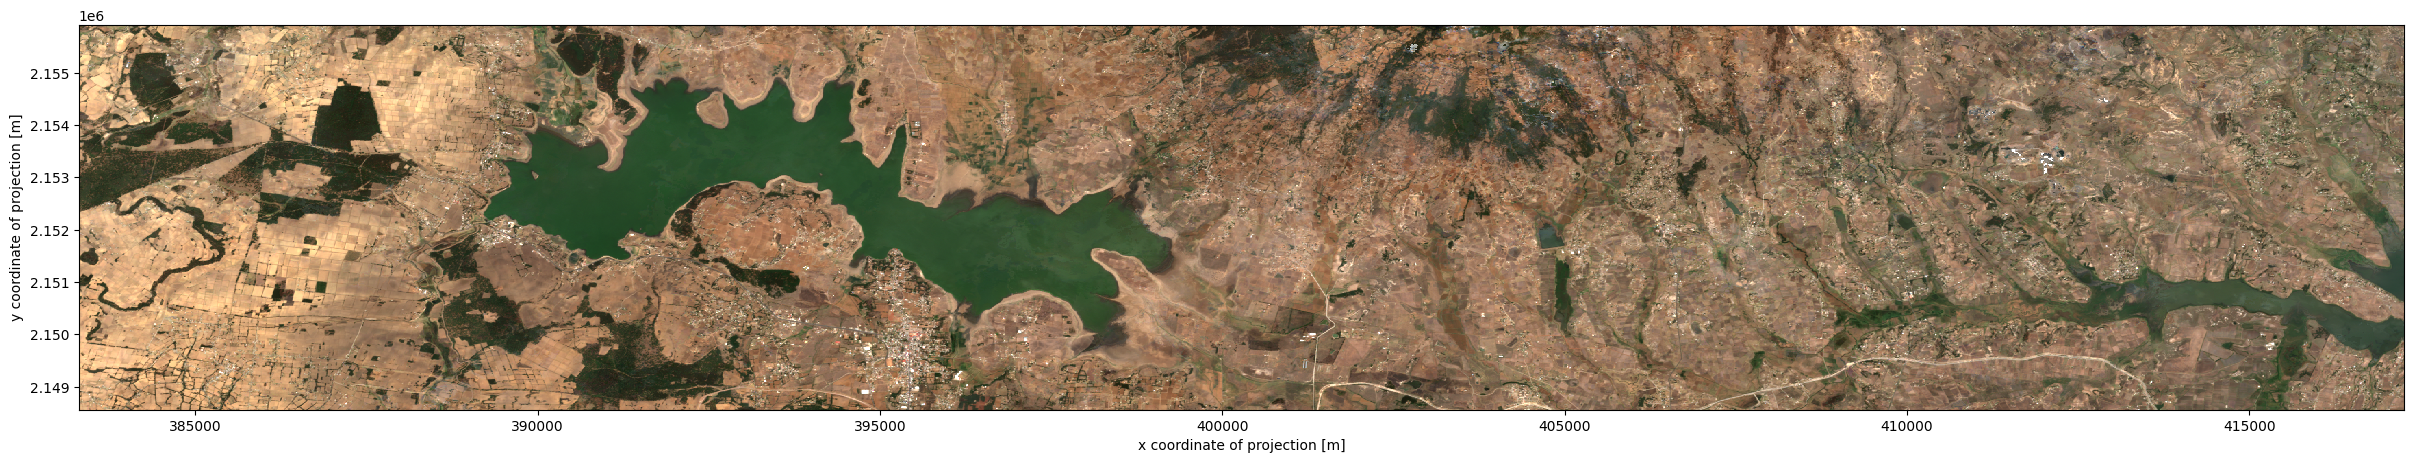

In [17]:
ds_s2_cube_median = xr.open_dataset("s2_cube_median/openEO.nc").load()
ds_s2_cube_median[['B04', 'B03', 'B02']].to_array().plot.imshow(x="x", robust=True, vmin=0, vmax=3000,figsize=(30,5))